In [1]:
import pandas as pd      
import numpy as np   
import datetime as dt
import yfinance as yf
# Importing packages to plot
import matplotlib.pyplot as plt

In [ ]:
# Loading data for S&P 500 time-series
data_source = yf.Ticker('^GSPC')

# Alternatively can load FTSE100
# data_source = yf.Ticker('^FTSE')

data_hist = data_source.history(period='max')
# Print data history
data_hist

In [3]:
# Filter data from 1990
data = data_hist["1990-01-01":"2009-12-31"].copy()

# Check for null and zero entries 
len(
  data[
    data.Close.isna() |
    data.Close.isnull() |
    data.Close < 1e-8
  ]
)

0

In [ ]:
# Plotting prices
data.Close.plot()
plt.ylabel("Price");

In [5]:
data = data_hist["1988-12-01":"2009-12-31"].copy()

In [6]:
def calc_returns(srs, offset=1):
    """ 
        Parameters:
              srs: pandas time-series
              offset: number of days to offset returns
        Return:
          Calculates the returns over the past number of days 
          specified by offset
    """
    
    returns = (srs - srs.shift(offset)) / srs.shift(offset)
    
    return returns

In [ ]:
data["daily_returns"] = calc_returns(data["Close"])
data["next_day_returns"] = data["daily_returns"].shift(-1)
data.head()

In [ ]:
# Limit data to within 5 standard deviations
# Winsorise the data by capping it to be within 5 x standard deviations
VOL_THRESHOLD = 5  
data["srs"] = data["Close"]

# Smooth annual lookback window (Approx. 252 trading days/year)
SMOOTH_WINDOW = 252 


ewm = data["srs"].ewm(halflife=SMOOTH_WINDOW)
# Calculate the exponentially-weighted moving mean
means = ewm.mean()
# Calculate the exponentially-weighted moving standard deviation
stds = ewm.std()

# Calculating upper bound
ub = means + VOL_THRESHOLD * stds
data["srs"] = np.minimum(data["srs"], ub);

# Calculating lower bound
lb = means - VOL_THRESHOLD * stds
data["srs"] = np.maximum(data["srs"], lb);

# Next day return without capping but returns for signal with capping
data["daily_returns"] = calc_returns(data["srs"],1)

plt.plot(data["daily_returns"]);

In [10]:
# Rescale volatility for comparison
def rescale_to_target_volatility(srs,vol=0.15):
    return srs *  vol / srs.std() / np.sqrt(252)

def plot_captured_returns(next_day_captured, plot_with_equal_vol = None):
    """ Parameters:
            next_day_captured: time-series of next day returns
        Return:
            matplotlib.pyplot of cumulative returns """
    
    if plot_with_equal_vol is not None:
        srs = rescale_to_target_volatility(next_day_captured.copy(),vol=plot_with_equal_vol)
    else:
        srs = next_day_captured.copy()
        
    ((srs.shift(1) + 1).cumprod() - 1).plot()
    plt.ylabel("Cumulative  returns");

In [ ]:
# Load long-only returns and plot
captured_returns_longonly = data['next_day_returns']["1990-01-01":]
plot_captured_returns(captured_returns_longonly)

In [12]:
def calc_downside_deviation(srs):
    """ Parameters:
            srs: pandas time-series
        Return:
            Downside Deviation (defined above) """
    negative_returns = srs.apply(lambda x: x if x < 0 else np.nan).dropna() * np.sqrt(252)
    return negative_returns.std()

def calc_max_drawdown(srs):
    """ Parameters:
            srs: pandas time-series
        Return:
            MDD (defined above) """
    cumulative_max = srs.cummax()
    drawdown = cumulative_max - srs
    return drawdown.max()

def calc_profit_and_loss_ratio(srs):
    """ Parameters:
            srs: pandas time-series
        Return:
            PnL ratio (defined above) """
    return np.mean(srs[srs>0])/np.mean(np.abs(srs[srs<0]))

In [ ]:
def calculate_statistics(next_day_captured, print_results=True):
    """ Parameters:
            srs: pandas time-series
            print_results: bool to print statistics
        Return:
            Metrics and risk adjusted performance metrics (defined above) """
    
    
    srs = next_day_captured.shift(1)
    mean = srs.mean()
    vol = srs.std()
    
    # Calculate annualised metrics:
    returns_annualised =  mean*252
    vol_annualised = vol*np.sqrt(252)
    downside_devs_annualised = calc_downside_deviation(srs)
    max_drawdown = calc_max_drawdown(srs)
    pnl_ratio = calc_profit_and_loss_ratio(srs)
    perc_positive_return = len(srs[srs>0])/len(srs)
    
    """
        Exercise: complete the following ratio definitions
    """
    # Calculate risk-adjusted performance metrics:
    
    sharpe = mean/vol*np.sqrt(252)   
    sortino = mean / downside_devs_annualised * 252
    calmar = mean / max_drawdown * 252
    
    # Print results
    if print_results:
        print("\033[4mPerformance Metrics:\033[0m")
        print(f"Annualised Returns = {returns_annualised:.2%}")
        print(f"Annualised Volatility = {vol_annualised:.2%}")
        print(f"Downside Deviation = {downside_devs_annualised:.2%}")
        print(f"Maximum Drawdown = {max_drawdown:.2%}")
        print(f"Sharpe Ratio = {sharpe:.2f}")
        print(f"Sortino Ratio = {sortino:.2f}")
        print(f"Calmar Ratio = {calmar:.2f}")
        print(f"Percentage of positive returns = {perc_positive_return:.2%}")
        print(f"Profit/Loss ratio = {pnl_ratio:.3f}")
   
    # Return performance metrics
    return {
        "returns_annualised":  returns_annualised,
        "vol_annualised": vol_annualised,
        "downside_deviation_annualised": downside_devs_annualised,
        "max_drawdown": max_drawdown,
        "sharpe": sharpe,
        "sortino": sortino,
        "calmar": calmar,
        "pnl_ratio": pnl_ratio,
      }

# Calculate performance metrics for basic long-only strategy defined
stats_longonly = calculate_statistics(captured_returns_longonly)

In [21]:
VOL_LOOKBACK = 60 # Lookback window for calculating daily volatility
VOL_TARGET = 0.15 # Setting annualised volatility target

def volatility_scaled_returns(daily_returns, vol_lookback = VOL_LOOKBACK, vol_target = VOL_TARGET):
    """ Parameters:
            daily_returns: pandas time-series of the daily returns
            print_results: bool to print statistics
        Return:
            Volatility scaled returns for annualised VOL_TARGET of 15% """
    
    #  Complete function
    # Calculate daily volatility
    volatility = daily_returns.ewm(span=vol_lookback).std()

    # Calculate scaled returns
    scaled_returns = (vol_target / volatility) * daily_returns.shift(-1)
    
    return scaled_returns

In [22]:
# Calculate volatility scaled returns
data['scaled_returns'] = volatility_scaled_returns(data["daily_returns"])
print(f"Signal annualised volatility: {data['scaled_returns'].std()*np.sqrt(252):.2%}")

Signal annualised volatility: 246.40%


In [23]:
data["trading_rule_signal"] = (1 + data["scaled_returns"]).cumprod()
data["scaled_next_day_returns"] = data["scaled_returns"].shift(-1)

In [ ]:
captured_returns_volscaled_lo = data["scaled_next_day_returns"]["1990-01-01":]
# Plot unscaled returns
plot_captured_returns(captured_returns_longonly, plot_with_equal_vol = VOL_TARGET)
# Plot volatility-scaled returns
plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
plt.legend(["Unscaled", "Vol. scaled"]);

In [ ]:
print("Vol. scaled long only:")
stats_volscaled_longonly = calculate_statistics(captured_returns_volscaled_lo)

In [ ]:
print("Unscaled long only:")
stats_longonly = calculate_statistics(captured_returns_longonly)

In [27]:
# Note that you are using the volatility-scaled framework
data["annual_returns"] = calc_returns(data["srs"], 252)

In [ ]:
# With the calculated returns, adjust your trading position accordingly
captured_returns_volscaled_tsmom = (
    np.sign(data["annual_returns"])*data["scaled_next_day_returns"]
)["1990-01-01":]

# Plot the time series momentum strategy against the long-only strategy
plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
plot_captured_returns(captured_returns_volscaled_tsmom, plot_with_equal_vol = VOL_TARGET)
plt.legend(["Long Only", "TSMOM"]);

In [ ]:
# Calculate performance metrics
stats_volscaled_tsmom = calculate_statistics(captured_returns_volscaled_tsmom)

In [ ]:
# Calculate returns for different timescales
returns_1w = data["srs"].pct_change(5)  # 1 week (5 trading days)
returns_1m = data["srs"].pct_change(20)  # 1 month (20 trading days)
returns_1q = data["srs"].pct_change(63)  # 1 quarter (63 trading days)
returns_half_year = data["srs"].pct_change(126)  # Half a year (126 trading days)

# Calculate cumulative returns for each timescale
cum_returns_1w = (1 + returns_1w).cumprod() - 1
cum_returns_1m = (1 + returns_1m).cumprod() - 1
cum_returns_1q = (1 + returns_1q).cumprod() - 1
cum_returns_half_year = (1 + returns_half_year).cumprod() - 1

# Plot cumulative returns for different timescales
plt.plot(cum_returns_1w, label="1 Week")
plt.plot(cum_returns_1m, label="1 Month")
plt.plot(cum_returns_1q, label="1 Quarter")
plt.plot(cum_returns_half_year, label="Half Year")

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns for Different Timescales")
plt.legend()
plt.show()

In [ ]:
weightings = [0.0, 0.25, 0.5, 0.75, 1.0]

# Initialize an empty DataFrame to store the combined signals
combined_signals = pd.DataFrame(index=data.index)

# Calculate the combined signals for each weighting
for w in weightings:
    signal_1m = np.sign(data["srs"].pct_change(20))
    signal_1y = np.sign(data["srs"].pct_change(252))
    combined_signal = w * signal_1m + (1 - w) * signal_1y
    combined_signals[f"w={w}"] = combined_signal

# Print the combined signals DataFrame
print(combined_signals)

In [35]:
# Define position sizing function
def phi(y):
    return y * np.exp(-(y ** 2) / 4) / 0.89

# Short and long trend combinations used for MACD
MACD_TREND_COMBINATIONS = [(8, 24), (16, 48), (32, 96)]

class MACDStrategy:
    def __init__(self, trend_combinations=None):
        # Setting parameters
        self.x_vol_window = 63
        self.y_vol_window = 252

        if trend_combinations is None:
            self.trend_combinations = MACD_TREND_COMBINATIONS
        else:
            self.trend_combinations = trend_combinations

    def compute_indiv_signal(self, prices, short_window, long_window):
        # Compute individual signals

        # Compute trend over short timescale
        short_trend = prices.ewm(alpha=1.0/short_window).mean()
        # Compute trend over long timescale
        long_trend = prices.ewm(alpha=1.0/long_window).mean()

        x = short_trend - long_trend
        y = x / prices.rolling(self.x_vol_window).std().fillna(method="bfill")
        z = y / y.rolling(self.y_vol_window).std().fillna(method="bfill")
        return z

    def get_signal(self, prices):
        # Calculate combined signal
        trend_combinations = self.trend_combinations
        signal_df = None
        
        for short_window, long_window in trend_combinations:

            indiv_signal = self.compute_indiv_signal(prices, short_window, long_window)

            if signal_df is None:
                signal_df = phi(indiv_signal)
            else:
                signal_df += phi(indiv_signal)

        return signal_df / len(trend_combinations)

In [ ]:
x = np.linspace(-5,5, 100)
plt.plot(x,phi(x));

In [ ]:
# Calculate returns using MACD
captured_returns_volscaled_macd = (
    MACDStrategy().get_signal(data["srs"])*data["scaled_next_day_returns"]
)["1990-01-01":]

# Plot cumulative returns of MACD vs long only
plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
plot_captured_returns(captured_returns_volscaled_macd, plot_with_equal_vol = VOL_TARGET)
plt.legend(["Long Only", "MACD"]);

In [ ]:
# Initialize a list to store the captured returns for each filter
captured_returns_macd_filters = []

# Calculate returns using MACD and different filters
for short_window, long_window in MACD_TREND_COMBINATIONS:
    macd_strategy = MACDStrategy([(short_window, long_window)])
    captured_returns_macd = macd_strategy.get_signal(data["srs"]) * data["scaled_next_day_returns"]
    captured_returns_macd_filters.append(captured_returns_macd)

# Rescale the captured returns to have 15% volume
rescaled_captured_returns_macd_filters = [capture_returns for capture_returns in captured_returns_macd_filters]

# Plot the captured returns
for i, rescaled_returns in enumerate(rescaled_captured_returns_macd_filters):
    plot_captured_returns(rescaled_returns, plot_with_equal_vol=0.15)

# Add legend and title to the plot
plt.legend([f"Filter {i+1}" for i in range(len(rescaled_captured_returns_macd_filters))])
plt.title("Captured Returns of MACD with Different Filters (Rescaled to 15% Volume)")

# Display the plot
plt.show()

In [42]:
correlation = np.corrcoef(captured_returns_volscaled_lo, captured_returns_volscaled_tsmom)[0, 1]

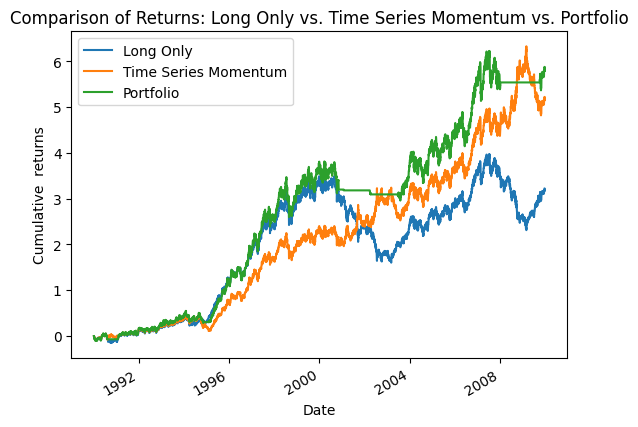

In [43]:
# Calculate the equally weighted portfolio returns
portfolio_returns = 0.5 * captured_returns_volscaled_lo + 0.5 * captured_returns_volscaled_tsmom

# Plot the returns of the portfolio and individual strategies
plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol=0.15)
plot_captured_returns(captured_returns_volscaled_tsmom, plot_with_equal_vol=0.15)
plot_captured_returns(portfolio_returns, plot_with_equal_vol=0.15)

# Add legend and title to the plot
plt.legend(["Long Only", "Time Series Momentum", "Portfolio"])
plt.title("Comparison of Returns: Long Only vs. Time Series Momentum vs. Portfolio")

# Display the plot
plt.show()